In [10]:
import numpy as numpy
import pandas as pandas
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname,filename)


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as numpy
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd






In [12]:
dataset_path=r"C:\Users\palle\OneDrive\Desktop\IPD-4\Blood-group-prediction\dataset_blood_group"

In [13]:
BATCH_SIZE = 32

In [14]:
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [15]:
class_names=dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1
print('Class Distribution:')
for i,count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
AB-: 761
A+: 565
O-: 712
O+: 852
B+: 652
AB+: 708
A-: 1009
B-: 741


In [16]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names,class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    classes = [class_counts[i] for i in class_counts.keys()]

In [17]:
plot_class_distribution(class_names, class_counts)


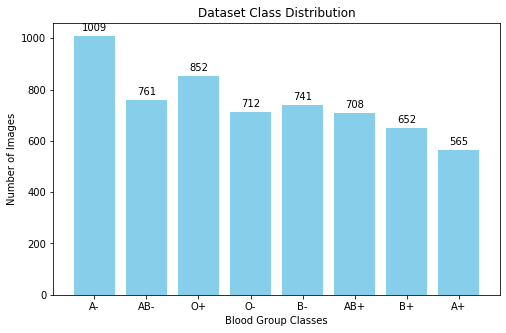

In [18]:
import matplotlib.pyplot as plt

# Define the class names (blood groups)
class_names = ['A-', 'AB-', 'O+', 'O-', 'B-', 'AB+', 'B+', 'A+']

# Corresponding count of images for each class
count = [1009, 761, 852, 712, 741, 708, 652, 565]

# Create bar chart
plt.figure(figsize=(8, 5))  # Set figure size
plt.bar(class_names, count, color='skyblue')  # Bar chart with color
plt.xlabel("Blood Group Classes")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")

# Annotate each bar with its value
for i, v in enumerate(count):
    plt.text(i, v + 20, str(v), ha='center', fontsize=10)

plt.show()


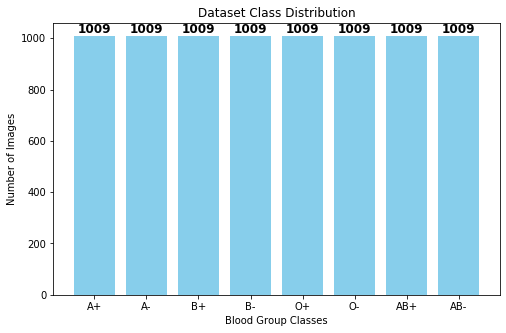

In [19]:
import matplotlib.pyplot as plt
max_count = max(class_counts.values())
# Sample data
class_names = ["A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-"]
count = [1009, 761, 852, 712, 741, 708, 652, 565]

plt.figure(figsize=(8, 5))  # Set figure size
bars = plt.bar(class_names, max_count, color='skyblue')

# Adding text on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get bar height
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel("Blood Group Classes")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")

# Show the plot
plt.show()


In [20]:
max_count = max(class_counts.values())

In [21]:
def oversample_class(class_id, count, max_count):
    unbatched_dataset = dataset.unbatch()
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))
    repeat_factor = max_count // count + (max_count % count > 0)
    return class_dataset.repeat(repeat_factor).take(max_count)

In [22]:
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))
balanced_dataset = tf.data.experimental.sample_from_datasets(balanced_datasets)
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)
balanced_dataset = balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)
plt.show()

In [23]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [44]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [25]:
# Unbatch the dataset to get individual samples
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Compute the total dataset size
dataset_size = sum(1 for _ in balanced_dataset_unbatched)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.20
test_ratio = 0.10

# Compute exact dataset sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
#test_size = dataset_size - (train_size + val_size)  # Ensure exact split
"""
print(f"Total dataset size: {dataset_size}")
print(f"Expected splits -> Train: {train_size}, Val: {val_size}, Test: {test_size}")
"""
# Re-create the dataset after computing size
balanced_dataset_unbatched = balanced_dataset.unbatch()  # Reinitialize iterator

# Split dataset correctly
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset= balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
#test_test_dataset= balanced_dataset_unbatched.skip(val_size)
test_dataset = val_test_dataset.skip(val_size)  # Remaining samples go to test

# Batch datasets correctly
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Compute final dataset sizes
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Final dataset sizes after batching:")
print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")



Final dataset sizes after batching:
Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [46]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64,64,3)),  # Change from (64,64,3) to (224,224,3)
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same',input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(10, activation='softmax')  # Assuming 10 classes
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a new model with updated input shape
create_high_acc_model = create_high_accuracy_model()


In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [102]:
history_high_acc = create_high_acc_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
176/176 [==============================] - 161s 901ms/step - loss: 7.9334 - accuracy: 0.1364 - val_loss: 2.2384 - val_accuracy: 0.1206
Epoch 2/50
176/176 [==============================] - 228s 1s/step - loss: 2.0698 - accuracy: 0.1653 - val_loss: 2.1433 - val_accuracy: 0.2031
Epoch 3/50
176/176 [==============================] - 250s 1s/step - loss: 1.8335 - accuracy: 0.2955 - val_loss: 1.8594 - val_accuracy: 0.3644
Epoch 4/50
176/176 [==============================] - 146s 823ms/step - loss: 1.4725 - accuracy: 0.4402 - val_loss: 1.9231 - val_accuracy: 0.1975
Epoch 5/50
176/176 [==============================] - 149s 840ms/step - loss: 1.2422 - accuracy: 0.5321 - val_loss: 1.5948 - val_accuracy: 0.4375
Epoch 6/50
176/176 [==============================] - 166s 937ms/step - loss: 1.0902 - accuracy: 0.5822 - val_loss: 1.5065 - val_accuracy: 0.5150
Epoch 7/50
176/176 [==============================] - 221s 1s/step - loss: 1.0467 - accuracy: 0.6051 - val_loss: 1.3215 - val_accu

In [103]:
high_acc_eval = create_high_acc_model.evaluate(val_dataset)    
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 [==============================] - 45s 236ms/step - loss: 0.3555 - accuracy: 0.8900
High Accuracy Model - Loss: 0.3554893434047699, Accuracy: 0.8899999856948853


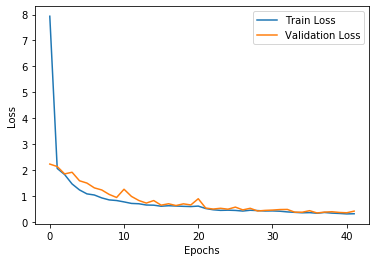

In [104]:
import matplotlib.pyplot as plt

plt.plot(history_high_acc.history['loss'], label='Train Loss')
plt.plot(history_high_acc.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


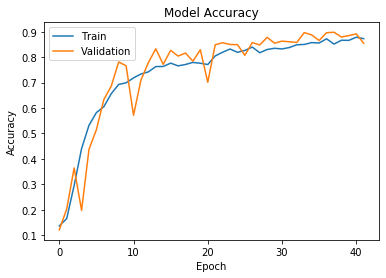

In [106]:
def plot_accuracy(history):
    import matplotlib.pyplot as plt  # Ensure Matplotlib is imported
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])  # Avoids errors if val_accuracy is missing
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_accuracy(history_high_acc)  # Call outside the function


In [130]:
import tensorflow as tf

test_data_path = r"C:\Users\palle\OneDrive\Desktop\IPD-4\Blood-group-prediction\dataset_blood_group"

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_path,
    image_size=(64,64),  # Adjust based on your model input size
    #label_mode="categorical",
    batch_size=32,
    shuffle=False
)
"""
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="categorical",  # One-hot encoding
    image_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True
)

"""

Found 6000 files belonging to 8 classes.


'\ndataset = image_dataset_from_directory(\n    dataset_path,\n    labels="inferred",\n    label_mode="categorical",  # One-hot encoding\n    image_size=(64, 64),\n    batch_size=BATCH_SIZE,\n    shuffle=True\n)\n\n'

Classification Report
              precision    recall  f1-score   support

          A+       0.95      0.95      0.95       565
          A-       0.89      0.85      0.87      1009
          B+       0.93      0.94      0.93       708
          B-       0.94      0.83      0.88       761
          O+       0.90      0.93      0.91       652
          O-       0.80      0.99      0.89       741
         AB+       0.90      0.90      0.90       852
         AB-       0.93      0.85      0.89       712

    accuracy                           0.90      6000
   macro avg       0.91      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



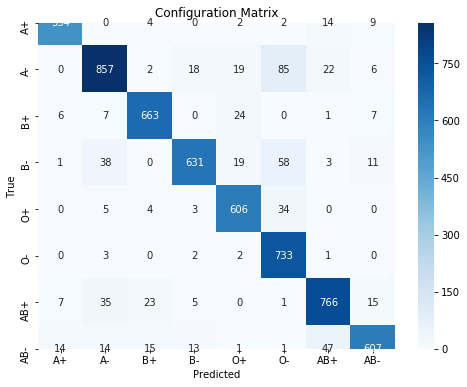

In [133]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = create_high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)
#class_names = ['A+', 'A-', 'O-', 'O+', 'AB+', 'B+', 'AB-', 'B-']
y_true = np.array(y_true)
y_pred = np.array(y_pred)
report = classification_report(y_true,y_pred,target_names=class_names)
print("Classification Report")
print(report)

conf_matrix = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Configuration Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
high_acc_model = create_high_acc_model  # Assign trained model

high_acc_model.save('model.h5')
print("Model saved.")


NameError: name 'create_high_acc_model' is not defined

In [5]:
high_acc_model.save('model.h5')
print("Model saved as HDF5 format")

NameError: name 'high_acc_model' is not defined

In [9]:
high_acc_model.save('model.h5')
print("Model saved as HDF5 format")

NameError: name 'high_acc_model' is not defined